<a href="https://colab.research.google.com/github/ramirogalvez/colab_notebooks/blob/master/Sentiment_Analysis_with_roBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author**: Ramiro Gálvez (Twitter handle: [@RamiroHGalvez](https://twitter.com/RamiroHGalvez))

**Date**: 2021-06-07

In [1]:
!pip install -qq transformers
!gdown --id 1CD7s5rnLbsQ7Bgx6WrSv6QwJe6_Q7dvy
!nvidia-smi

     |████████████████████████████████| 2.3MB 29.2MB/s 
     |████████████████████████████████| 901kB 51.1MB/s 
     |████████████████████████████████| 3.3MB 48.6MB/s 
Downloading...
From: https://drive.google.com/uc?id=1CD7s5rnLbsQ7Bgx6WrSv6QwJe6_Q7dvy
To: /content/imdb_data.zip
127MB [00:02, 57.1MB/s]
Tue Jun  8 21:23:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10

In [2]:
import requests
import zipfile
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from collections import defaultdict
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


In [3]:
# Seteos de la notebook
%matplotlib inline
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# roBERTa para Análisis de Sentimiento

En esta notebook se presenta el código para entrenar un modelo de análisis de sentimiento a partir de un modelo BERT (roBERTa) pre entrenado (transfer learning). La notebook hace uso fuerte de la librería transformers de huggingface y puede adaptarse de manera simple (trivial) a otros problemas de clasificación de textos (cortos).

## Carga de los datos

In [4]:
def process_document(metadata, document):

    m_id, rating = [int(e) for e in metadata.replace(".txt", "").split("_")]
    r_class = 0 if rating <= 4 else 1

    return {"movie_id": m_id,
            "rating": rating,
            "content": document,
            "sentiment": r_class}


def carga_path(data_path):

    comments_data = []
    for d in os.listdir(data_path):
        with open(data_path + d, encoding="utf-8") as f:
            comments_data.append(process_document(d, f.read()))

    return pd.DataFrame(comments_data)


def carga_datos_imdb(tr_path, ts_path):

    # Descarga el archivo zip y lo descomprime en el server de Google
    z = zipfile.ZipFile("imdb_data.zip")
    z.extractall()

    # Carga los datos de entrenamiento
    train_data = carga_path(tr_path)

    # Carga los datos de testeo
    test_data = carga_path(ts_path)

    return train_data, test_data

In [5]:
train_data, test_data = carga_datos_imdb("./imdb_data/imdb_data/train_corpus/",
                                         "./imdb_data/imdb_data/test_corpus/")
class_names = ['negative', 'positive']

train_data, val_data = train_test_split(train_data,
                                        test_size=0.1,
                                        random_state=RANDOM_SEED)

In [6]:
train_data.head()

,movie_id,rating,content,sentiment
4484,4089,8,Strangely erotic schlock Gothic horror that wi...,1
11558,7810,7,"What is ""Cry Freedom"" like? It is simply great...",1
16900,6168,10,"Aileen Gonsalves, my girlfriend, is in this fi...",1
8936,9639,10,A very close and sharp discription of the bubb...,1
10782,11213,3,OK ...I watch a lot of bad movies. I pride mys...,0


## Configuración de los data loaders para roBERTa

In [7]:
class SentimentDataset(Dataset):

    def __init__(self, contents, targets, tokenizer, max_len):
        self.contents = contents
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.contents)


    def __getitem__(self, item):
        content = str(self.contents[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(content,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation=True)

        return {'content_text': content,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}


def create_data_loader(df, tokenizer, max_len, batch_size):

    ds = SentimentDataset(contents=df.content.to_numpy(),
                          targets=df.sentiment.to_numpy(),
                          tokenizer=tokenizer,
                          max_len=max_len)
    
    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=2)

In [8]:
MAX_LEN = 400
BATCH_SIZE = 16
PRE_TRAINED_MODEL_NAME = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_data, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

## Seteo del modelo propuesto (roBERTa + dropout + fully connected)

In [9]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes, freeze = False):
    
        super(SentimentClassifier, self).__init__()
        self.model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.model.config.hidden_size, n_classes)

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False


    def forward(self, input_ids, attention_mask):

        _, pooled_output = self.model(input_ids=input_ids,
                                      attention_mask=attention_mask,
                                      return_dict=False)

        output = self.drop(pooled_output)

        return self.out(output)

In [10]:
model = SentimentClassifier(len(class_names), freeze=False)
model = model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=total_steps // 10,
                                            num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

In [12]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, 
                scheduler, n_examples):

    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in data_loader:

        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

## Entrenamiento

In [13]:
%%time
TRAIN_MODEL = False

if TRAIN_MODEL:
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(EPOCHS):

        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            len(train_data),
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device,
            len(val_data),
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_roBERTa_model_state.bin')
            best_accuracy = val_acc

    files.download('best_roBERTa_model_state.bin') 

else:

    !gdown --id 1tsdW4_HKA0c41ha7Y2NGHuCZklSjY1ic
    model = SentimentClassifier(len(class_names))
    model.load_state_dict(torch.load('best_roBERTa_model_state.bin'))
    model = model.to(device)

Epoch 1/6
----------
Train loss 0.27854714981100226 accuracy 0.8911111111111112
Val   loss 0.21704277749303846 accuracy 0.9336000000000001

Epoch 2/6
----------
Train loss 0.15758884123481173 accuracy 0.9566666666666667
Val   loss 0.2558794836439548 accuracy 0.9456

Epoch 3/6
----------
Train loss 0.09665178198308777 accuracy 0.9770666666666667
Val   loss 0.33738146022619875 accuracy 0.9412

Epoch 4/6
----------
Train loss 0.060667088524326 accuracy 0.9875111111111111
Val   loss 0.34124614324036595 accuracy 0.9416

Epoch 5/6
----------
Train loss 0.03521661871459688 accuracy 0.9931555555555556
Val   loss 0.3684980178052214 accuracy 0.9448000000000001

Epoch 6/6
----------
Train loss 0.01939945408961113 accuracy 0.9962222222222222
Val   loss 0.3717444732164776 accuracy 0.9448000000000001



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 3h 1min 55s, sys: 1min 8s, total: 3h 3min 4s
Wall time: 3h 3min 46s


## Evaluación del modelo entrenado

In [14]:
def get_predictions(model, data_loader):

    model = model.eval()

    content_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["content_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            _, preds = torch.max(outputs, dim=1)

            probs = nn.functional.softmax(outputs, dim=1)

            content_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return content_texts, predictions, prediction_probs, real_values

In [15]:
y_content_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader,
)

In [16]:
print(classification_report(y_test, y_pred, target_names=class_names))
test_roc = roc_auc_score(y_test, y_pred_probs[:,1].numpy())
print(test_roc)

              precision    recall  f1-score   support

    negative       0.96      0.94      0.95     12500
    positive       0.95      0.96      0.95     12500

    accuracy                           0.95     25000
   macro avg       0.95      0.95      0.95     25000
weighted avg       0.95      0.95      0.95     25000

0.9857340672


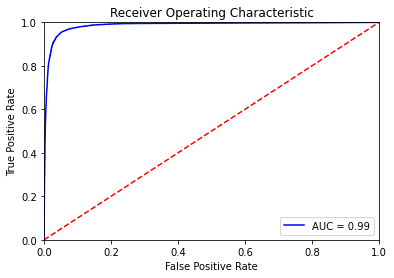

In [17]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_probs[:,1].numpy())
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % test_roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()